In [1]:
import geopandas as gpd
import pathlib
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import reverse_geocoder as rg
import pycountry_convert as pc
import seaborn as sns
import random

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle

/media/sambhav/Windows/ml/ml_venv/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


# load the dataset metadata


In [2]:
gpd_dataset_path = "sen12tp-metadata.json"

In [3]:
gdf = gpd.read_file(gpd_dataset_path)
# convert to crs 4326 to get lat lon
gdf = gdf.to_crs(epsg=4326)
gdf = gdf[["geometry"]]

# get lat lon of centroids
gdf["centroid"] = gdf["geometry"].centroid
gdf["lat"] = gdf["centroid"].y
gdf["lon"] = gdf["centroid"].x

/media/sambhav/Windows/ml/ml_venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  import sys


In [4]:
gdf.head()

geometry  \
0  POLYGON ((-70.41461 -34.46821, -70.41767 -34.6...   
1  POLYGON ((72.28826 34.05056, 72.29398 33.87029...   
2  POLYGON ((-8.42436 41.53311, -8.42595 41.35288...   
3  POLYGON ((6.72425 46.55625, 6.73174 46.37631, ...   
4  POLYGON ((-0.55427 42.60345, -0.56128 42.42341...   

                      centroid        lat        lon  
0  POINT (-70.30711 -34.55961) -34.559609 -70.307107  
1    POINT (72.39930 33.96274)  33.962744  72.399301  
2    POINT (-8.30540 41.44231)  41.442312  -8.305398  
3     POINT (6.85822 46.46877)  46.468772   6.858218  
4    POINT (-0.43611 42.51075)  42.510751  -0.436110

Text(0.5, 1.0, 'SEN12TP dataset locations')

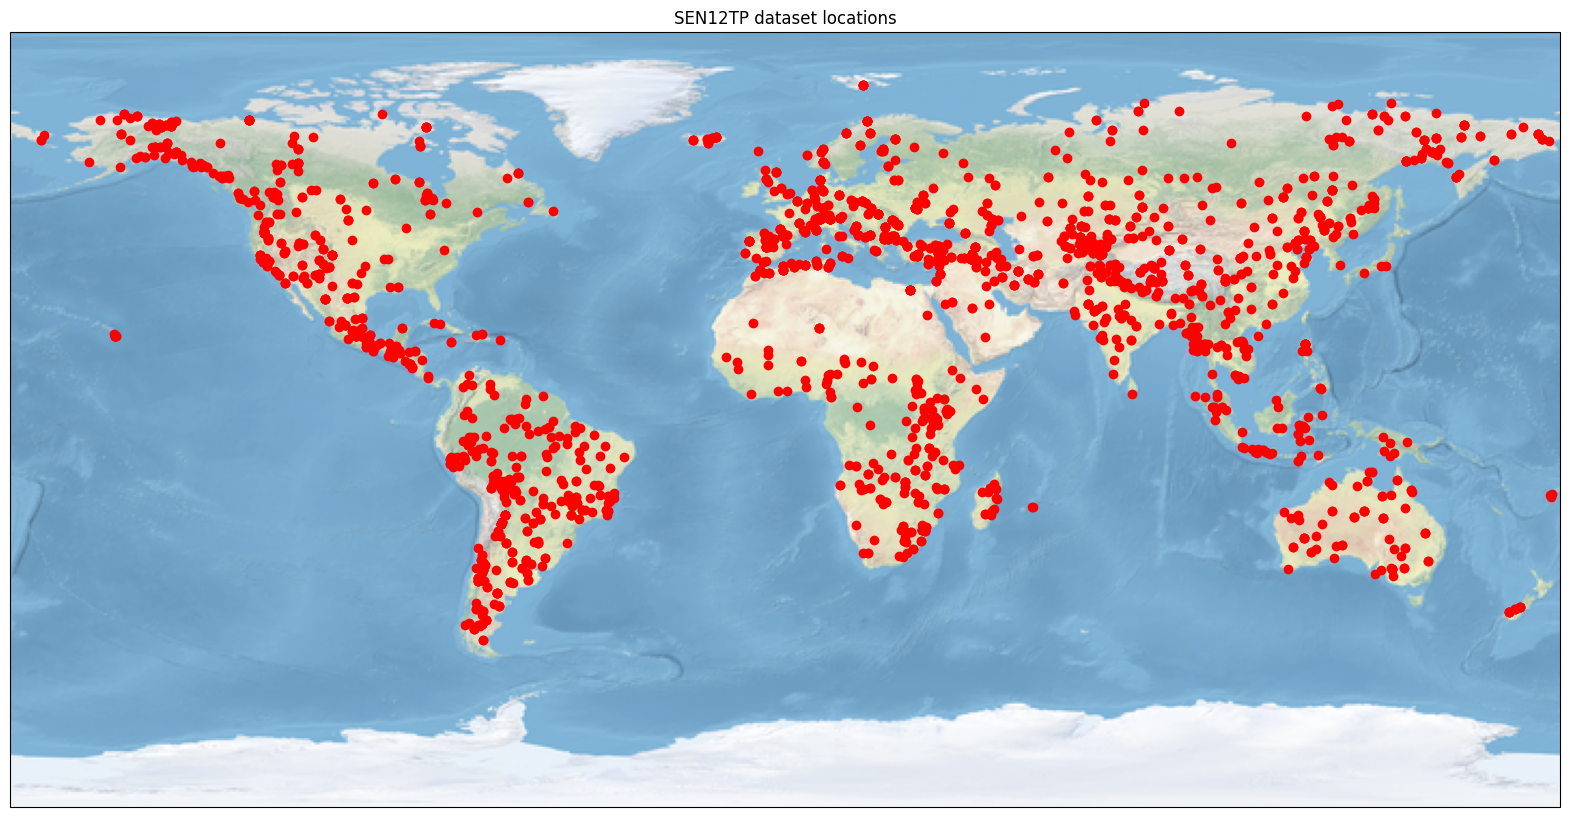

In [5]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

ax.plot(gdf["lon"], gdf["lat"], "o", color="r")
plt.title("SEN12TP dataset locations")

# reverse geocode all AOIs


In [6]:
# reverse geocode to get the continent
continent_dict = {
    "NA": "North America",
    "SA": "South America",
    "AS": "Asia",
    "AF": "Africa",
    "OC": "Oceania",
    "EU": "Europe",
    "AQ": "Antarctica",
}

gdf["continent_code"] = rg.search(list(map(tuple, gdf[["lat", "lon"]].values)))
gdf["continent_code"] = gdf["continent_code"].apply(
    lambda x: pc.country_alpha2_to_continent_code(x["cc"])
)
gdf["continent_name"] = gdf["continent_code"].apply(lambda x: continent_dict[x])

Loading formatted geocoded file...


In [7]:
gdf.head()

geometry  \
0  POLYGON ((-70.41461 -34.46821, -70.41767 -34.6...   
1  POLYGON ((72.28826 34.05056, 72.29398 33.87029...   
2  POLYGON ((-8.42436 41.53311, -8.42595 41.35288...   
3  POLYGON ((6.72425 46.55625, 6.73174 46.37631, ...   
4  POLYGON ((-0.55427 42.60345, -0.56128 42.42341...   

                      centroid        lat        lon continent_code  \
0  POINT (-70.30711 -34.55961) -34.559609 -70.307107             SA   
1    POINT (72.39930 33.96274)  33.962744  72.399301             AS   
2    POINT (-8.30540 41.44231)  41.442312  -8.305398             EU   
3     POINT (6.85822 46.46877)  46.468772   6.858218             EU   
4    POINT (-0.43611 42.51075)  42.510751  -0.436110             EU   

  continent_name  
0  South America  
1           Asia  
2         Europe  
3         Europe  
4         Europe

Text(0.5, 1.0, 'SEN12TP dataset locations')

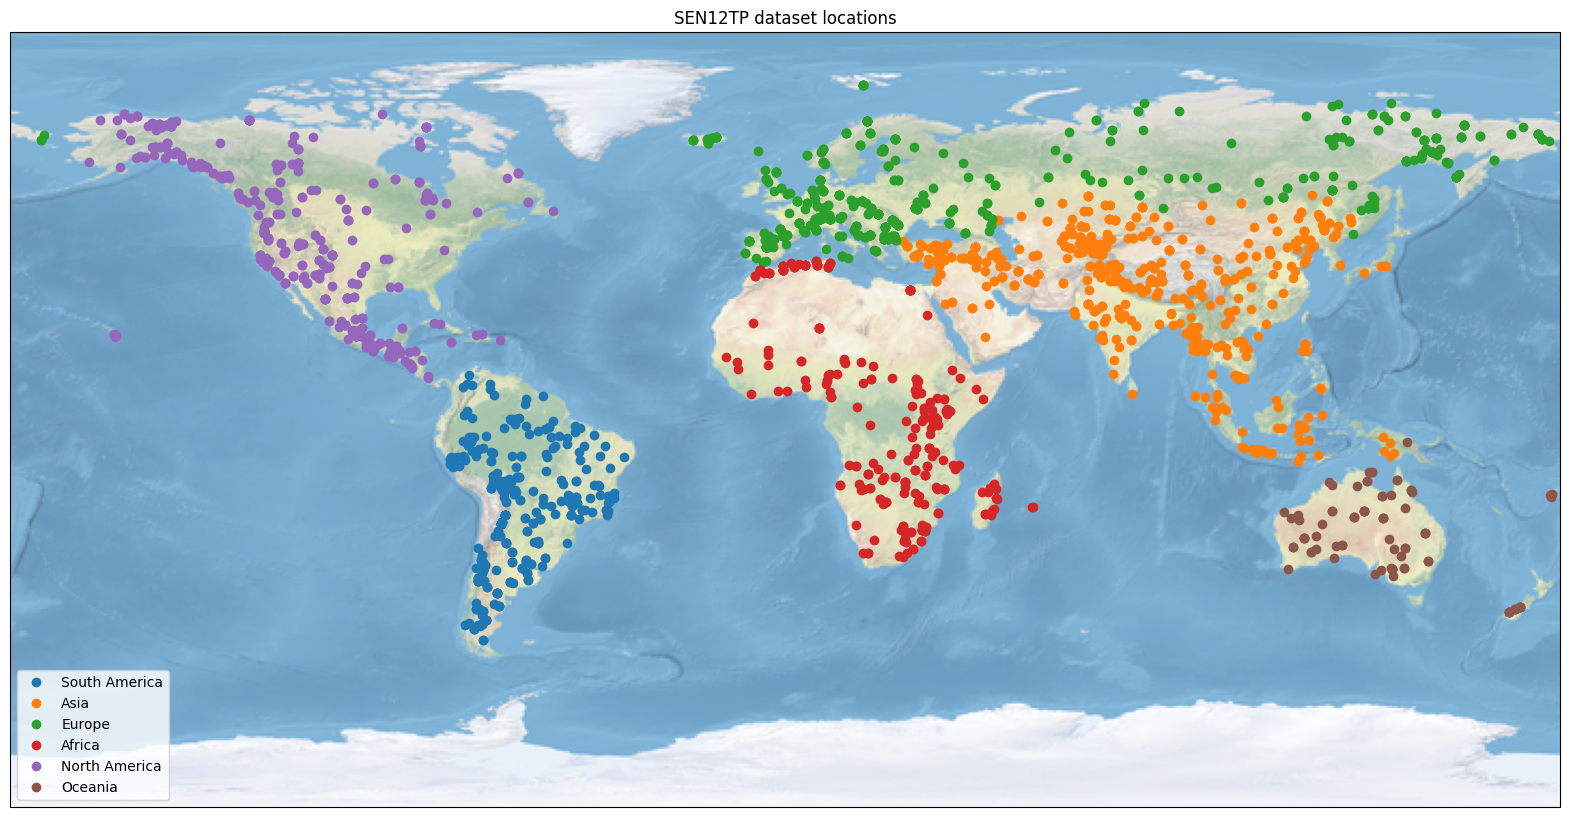

In [8]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for continent_name in gdf["continent_name"].unique():
    ax.plot(
        gdf[gdf["continent_name"] == continent_name]["lon"],
        gdf[gdf["continent_name"] == continent_name]["lat"],
        "o",
        label=continent_name,
    )

plt.legend()
plt.title("SEN12TP dataset locations")

Text(0, 0.5, 'Continent')

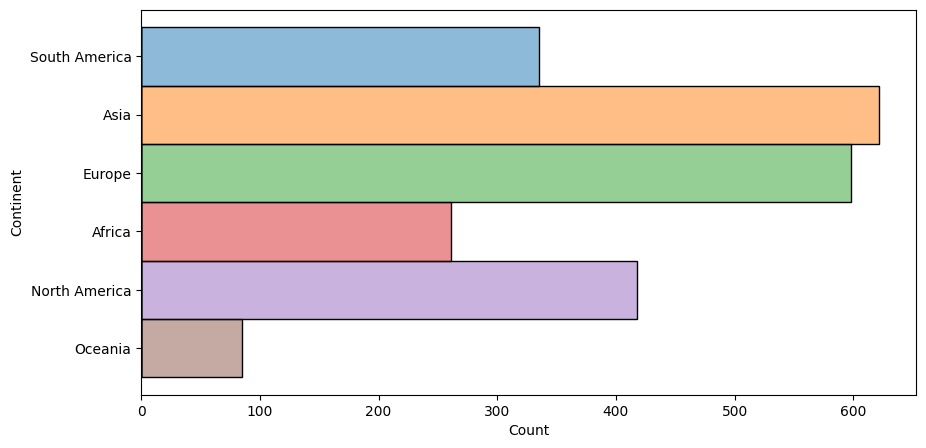

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(data=gdf, y="continent_name", hue="continent_name", legend=False)
plt.ylabel("Continent")

# Split out representative points for the test


In [10]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [11]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)


def get_n_filtered_pts(gdf_dbscan, max_pts=10, max_dist_km=200):
    coords = gdf_dbscan[["lat", "lon"]].values

    # look at this to understadnd - https://stackoverflow.com/a/49212829
    kms_per_radian = 6371.0088
    epsilon = max_dist_km / kms_per_radian

    db = DBSCAN(
        eps=epsilon, min_samples=1, algorithm="ball_tree", metric="haversine"
    ).fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])

    filtered_pts = list(clusters.map(lambda x: get_centermost_point(x)))

    if len(filtered_pts) > max_pts:
        filtered_pts = random.sample(filtered_pts, max_pts)

    return filtered_pts


num_pts_per_continent = 50
all_filtered_pts = []

for continent_name in gdf["continent_name"].unique():
    continent_gdf = gdf[gdf["continent_name"] == continent_name]
    all_filtered_pts.extend(get_n_filtered_pts(continent_gdf, num_pts_per_continent))

lats, lons = zip(*all_filtered_pts)
rep_points = pd.DataFrame({"lon": lons, "lat": lats})

filtered_gdf = rep_points.apply(
    lambda row: gdf[(gdf["lat"] == row["lat"]) & (gdf["lon"] == row["lon"])].iloc[0],
    axis=1,
)
filtered_gdf

geometry  \
0    POLYGON ((-60.41700903684795 -22.8466946515757...   
1    POLYGON ((-66.79824169493548 -26.7088448108728...   
2    POLYGON ((-68.31437884581001 -9.56723586277962...   
3    POLYGON ((-57.52714858703152 -28.5200819766743...   
4    POLYGON ((-67.2026965554495 -34.95799585129478...   
..                                                 ...   
280  POLYGON ((123.1608561070335 -26.99561740942468...   
281  POLYGON ((129.3750353815047 -29.02433751665054...   
282  POLYGON ((142.91739019216618 -31.6282748979851...   
283  POLYGON ((135.1166884553652 -14.20561821457216...   
284  POLYGON ((132.83548069115704 -15.4373678330881...   

                                            centroid        lat         lon  \
0      POINT (-60.31782220295396 -22.93535441284517) -22.935354  -60.317822   
1     POINT (-66.69586768055075 -26.797497065837693) -26.797497  -66.695868   
2      POINT (-68.22300834126706 -9.657524322139034)  -9.657524  -68.223008   
3    POINT (-57.425262533365604 -28.610734888871818) -28.610735  -57.425263   
4     POINT (-67.09107619054815 -35.046477310299124) -35.046477  -67.091076   
..                                               ...        ...         ...   
280   POINT (123.26190224101765 -27.085783187971384) -27.085783  123.261902   
281    POINT (129.47819360314722 -29.11429843142212) -29.114298  129.478194   
282    POINT (143.02478241610706 -31.71684377191985) -31.716844  143.024782   
283    POINT (135.2095012025954 -14.296011357143936) -14.296011  135.209501   
284    POINT (132.9277737255945 -15.528644888137034) -15.528645  132.927774   

    continent_code continent_name  
0               SA  South America  
1               SA  South America  
2               SA  South America  
3               SA  South America  
4               SA  South America  
..             ...            ...  
280             OC        Oceania  
281             OC        Oceania  
282             OC        Oceania  
283             OC        Oceania  
284             OC        Oceania  

[285 rows x 6 columns]

Text(0.5, 1.0, 'SEN12TP reprsentative points')

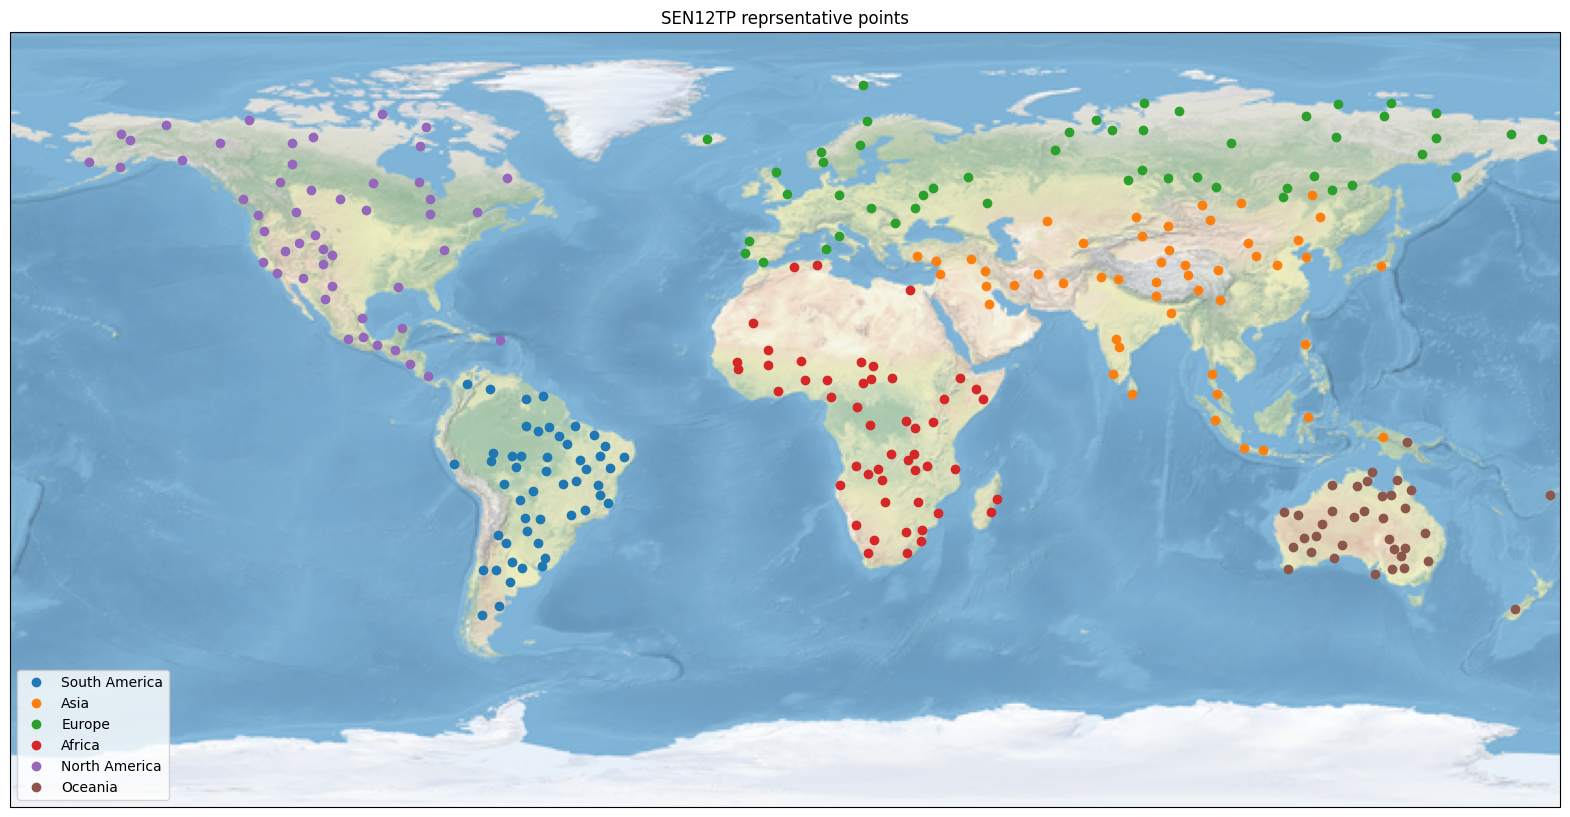

In [12]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

for continent_name in filtered_gdf["continent_name"].unique():
    ax.plot(
        filtered_gdf[filtered_gdf["continent_name"] == continent_name]["lon"],
        filtered_gdf[filtered_gdf["continent_name"] == continent_name]["lat"],
        "o",
        label=continent_name,
    )

plt.legend()
plt.title("SEN12TP reprsentative points")